**<font size=5 color='black'>逻辑回归</font>** 

**1** 介绍逻辑回归算法的基本原理

**2** 介绍逻辑回归模型参数的梯度下降求解方法

**3** 使用鸢尾花数据集，以二元逻辑回归为例， 对比本文算法与sklearn的结果

In [1]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np

**<font size=4 color='black'>1 算法概述</font>** <br>

**<font size=3.5 color='black'>1.1 数学模型</font>** 

+ 二元逻辑回归模型：$$ P(Y=1|x) = \frac{1}{1+e^{-(wx+b)}} = \frac{1}{1+e^{-(\theta x)}}, \theta = (b, w_1, w_2, ..., w_n), x = (1, x_1, x_2, ..., x_n)\tag{1}$$ $ wx $为$ w $和$ x $的**内积**，为方便表达，将$ b $和$ w $合并为$ \theta $，同时增加$ x $的维度，但这里不改变$ x $的表示符号。

+ 模型特性：$$ wx+b  = \theta x = ln \frac{P(Y=1|x)}{1 - P(Y=1|x)} \tag{2}$$ 即输出$Y=1$的对数几率是输入$x$的线性函数。当$ \theta x $趋近于正无穷时，$ P(Y=1|x) $趋近于1；当$ \theta x $趋近于负无穷时，$ P(Y=1|x) $趋近于0；当$ \theta x $趋近于0时，$ P(Y=1|x) $趋近于0.5

In [2]:
def sigmoid(t):
    """该函数对应前面的二元逻辑回归模型，称为sigmoid函数或者logistic函数
    Parameters
    ----------
    t: ndarray of shape (n_samples, 1)

    Returns
    -------
    out: ndarray of shape (n_samples, 1)
    """
    out = 1 / (1 + np.exp(-t))
    return out

**<font size=3.5 color='black'>1.2 损失函数</font>** 

+ 确定逻辑回归模型的数学形式后，接下来的目标是找到一个合适的损失函数，并基于该目标求解模型参数。对于二分类问题，模型最终输出只有两种结果（Y=1和Y=0），由于逻辑回归直接输出的是$P(Y=1|x)$或$P(Y=0|x)$，也就是概率值，因此可以利用极大似然估计的思想，即寻找一组参数，使得在这组参数下，我们的数据对应的概率最大。

+ 令：$ P(Y=1|x) = h_\theta(x), P(Y=0|x) = 1 - h_\theta(x) $<br>
似然函数：
$$ L(\theta) = \prod_{i=1}^m[h_\theta(x^{(i)})]^{y^{(i)}}[1 - h_\theta(x^{(i)})]^{1 -y^{(i)}} (y=0,1) \tag{3}$$
其中，m为样本数；$ x^{(i)} $为第i个样本向量；$ y^{(i)} $为第i个样本标签。<br>
取ln得：
$$ lnL(\theta) = \sum_{i=1}^m [y^{(i)}lnh_\theta(x^{(i)}) + (1-y^{(i)})ln(1-h_\theta(x^{(i)}))] = \sum_{i=1}^m[y^{(i)} \cdot \theta x^{(i)} - ln(1+e^{\theta x^{(i)}}]\tag{4}$$<br>
+ **取数据集的平均对数似然损失作为损失函数**：
$$ J(\theta) = -\frac{1}{m}lnL(\theta) \tag{5}$$ <br>
加负号的原因是将原本求概率最大的问题转化为求最小，也就是将原本的梯度上升求解转化为梯度下降求解，这样做的目的是便于类比线性回归。<br>
<font size=4 color='red'>注意：</font> 当样本标签$y \in \{ 1, -1\}$时，逻辑回归的损失函数有所变化，但本质上是一致的，具体可以参考[paper](https://eprint.iacr.org/2018/074.pdf)。

In [3]:
def logistic_loss(theta, X, y):
    """计算损失
    Parameters
    ----------
    theta: ndarray of shape (1+n_features, 1)
    X: ndarray of shape (n_samples, 1+n_features)
    y: ndarray of shape (n_samples, 1)

    Returns
    -------
    loss: float
    """
    y_hat = sigmoid(X.dot(theta))
    loss = -(y.T.dot(np.log(y_hat)) + (1-y).T.dot(np.log(1-y_hat))) / len(y)
    return loss[0][0]

**<font size=4 color='black'>2 梯度下降</font>**

**<font size=3.5 color='black'>2.1 梯度计算公式</font>** 

$$ \frac{\partial}{\partial \theta_j}J(\theta) = -\frac{1}{m}\sum_{i=1}^{m}[x_j^{(i)}y^{(i)}-x_j^{(i)}\frac{e^{\theta x^{(i)}}}{1+e^{\theta x^{(i)}}}] = \frac{1}{m} \sum_{i=1}^{m}[h_\theta(x^{(i)})-y^{(i)}]x_j^{(i)}\tag{6}$$

可以发现，该公式与线性回归部分的对应公式高度统一！只是$h_\theta(x^{(i)})$所表达的函数形式有所不同，逻辑回归的$h_\theta(x^{(i)})$相当于在线性回归函数模型的基础上套了个“外套”，即映射。

In [4]:
def logistic_grad(theta, X, y):
    """计算梯度
    Parameters
    ----------
    theta: ndarray of shape (1+n_features, 1)
    X: ndarray of shape (n_samples, 1+n_features)
    y: ndarray of shape (n_samples, 1)

    Returns
    -------
    grad: ndarray of shape (1+n_features, 1)
    """
    y_hat = sigmoid(X.dot(theta))
    grad = X.T.dot(y_hat - y) / len(y)
    return grad

**<font size=3.5 color='black'>2.2 参数更新公式</font>** 

$$ \theta_j^k = \theta_j^{k-1} - \eta J^{'}(\theta_j^{k-1}) \tag{7}$$

In [5]:
def gradient_descent(X, y, initial_theta, eta, max_iter=10000, tol=1e-4):
    """批量梯度下降法（FG）
    Parameters
    ----------
    X: ndarray of shape (n_samples, 1+n_features)
    y: ndarray of shape (n_samples, 1)
    initial_theta: ndarray of shape (1+n_features, 1) theta的初始值 
    eta: float 学习率
    max_iter: int 最大迭代次数 
    tol: float 梯度的阈值

    Returns
    -------
    theta: ndarray of shape (1+n_features, 1) theta的求解结果
    loss_path: list loss更新列表
    """
    theta = initial_theta
    cur_iter = 1
    loss_path = []
    loss_path.append(logistic_loss(theta, X, y))  # 存储初始损失函数值

    while cur_iter <= max_iter:
        grad = logistic_grad(theta, X, y)
        theta = theta - eta * grad
        loss_path.append(logistic_loss(theta, X, y))
        if all(abs(grad) < tol):
            break
        cur_iter += 1

    return theta, loss_path

**<font size=4 color='black'>5 案例</font>**

**5.1 数据准备**

+ 鸢尾花数据集包含150行数据记录，特征维度为4，标签有3类（1-50条记录的类别为0，51-100行类别为1，100-150行为类别2）。<br>
+ 由于本文研究的是二分类逻辑回归问题，同时为了方便可视化，直观表达分类效果，**这里只取前100行以及前2列数据做研究**。数据示例：<br>

|Sepal_Length|Sepal_Width|Petal_Length|Petal_Width|Species|
|:----------:|:---------:|:----------:|:---------:|:-----:|
|5.1         |3.5        |1.4         |0.2        |setosa |
|4.9         |3.0        |1.4         |0.2        |setosa |
|4.7         |3.2        |1.3         |0.2        |setosa |
|4.6         |3.1        |1.5         |0.2        |setosa |

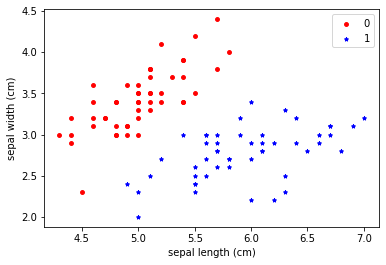

In [6]:
iris = load_iris()
feature_names = iris.feature_names
target_names = iris.target_names

# 取前100行、前2列数据
X = iris.data
X = X[:100, :2]
y = iris.target
y = y[:100]

# 使用前2个特征可视化数据
index_0 = np.where(y == 0)
index_1 = np.where(y == 1)
fig = plt.figure()
ax = plt.axes()
ax.scatter(X[index_0[0], 0], X[index_0[0], 1],
           marker='o', c='r', s=15, label='0')
ax.scatter(X[index_1[0], 0], X[index_1[0], 1],
           marker='*', c='b', s=15, label='1')
ax.set(xlabel=feature_names[0], ylabel=feature_names[1])
ax.legend()

**5.2 结果对比**

In [7]:
# 本文算法
X_ = np.hstack([np.ones((100, 1)), X])  # 增加X的维度以适应矩阵运算
y_ = y.reshape(-1, 1)  # 将y转换成一个列向量以适应矩阵运算
initial_theta = np.ones((X_.shape[1], 1))
theta, loss_path = gradient_descent(
    X_, y_, initial_theta, eta=0.278, max_iter=65000, tol=1e-4)
grad = logistic_grad(theta, X_, y_)

print('本文算法')
print('-------')
print('第{}次迭代停止'.format(len(loss_path) - 1))
print('theta：\n', theta)
print('gradient：\n', grad)

本文算法
-------
第65000次迭代停止
theta：
 [[-24.31826725]
 [ 11.69325041]
 [-12.50897045]]
gradient：
 [[ 0.00064867]
 [-0.00019459]
 [ 0.00012466]]


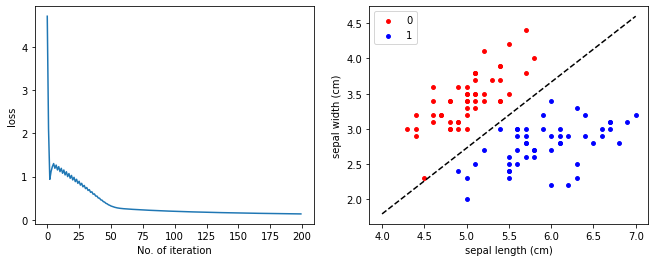

In [8]:
fig2, axes = plt.subplots(1, 2, figsize=(11, 4))

# 损失函数值变化过程图
axes[0].plot(range(len(loss_path[:200])), loss_path[:200])  # 取前200次迭代结果展示
axes[0].set(xlabel='No. of iteration', ylabel='loss')

# 分类结果图
x1 = np.arange(4.0, 7.5, 0.5)
x2 = (-theta[0][0] - theta[1][0]*x1) / theta[2][0]
axes[1].scatter(X[index_0[0], 0], X[index_0[0], 1],
                marker='o', c='r', s=15, label='0')
axes[1].scatter(X[index_1[0], 0], X[index_1[0], 1],
                marker='o', c='b', s=15, label='1')
axes[1].plot(x1, x2, linestyle='--', color='k', linewidth=1.5)
axes[1].set(xlabel=feature_names[0], ylabel=feature_names[1])
axes[1].legend()

+ 从上述计算结果可以看出，算法达到最大迭代次数，此时对应的梯度并未达到收敛条件（梯度小于1e-4），这是正常的。因为从loss图像可以看出，在前50次迭代过程中有明显的“振荡”，这说明$\eta$值设置的较大，导致梯度下降时“步子迈的太大”，同时这也导致了最终没有达到梯度收敛条件，而是达到最大迭代次数后停止。
+ $\eta$值是本文经过多次试验人为设定的，可以发现最终的分类结果很好地区分了两种类别。但实际上对于$\eta$值的确定有很多优秀的方法，这里只是为了简单说明逻辑回归方法，因此并未针对$\eta$值的设定问题进行深入探讨。
+ 由于逻辑回归的损失函数$J(\theta)$是一个**凸函数**，因此理论上可以通过设定一个很小的$\eta$以及很大的max_iters来不断迭代找到一个最小值点，但由于计算时间、计算资源等的限制，通常我们不会去做，只需要满足我们的精度需求即可。<br>

**<font size=3 color='red'>说明：</font>**本文不过多考虑过拟合、预测等问题，仅限于通过简单例子理解模型的思想和处理过程。

In [9]:
# sklearn
logreg = LogisticRegression(penalty='none', solver='sag',
                            max_iter=10000, tol=1e-4)
# penalty='none' 不进行正则化
# solver='sag' 采用随机平均梯度下降法求解参数
# max_iter=10000 最大迭代次数
# tol=1e-4 停止迭代的容差
logreg.fit(X, y)

print('sklearn')
print('-------')
print('第{}次迭代停止'.format(logreg.n_iter_))
print('w：\n', logreg.coef_)
print('b：\n', logreg.intercept_)

sklearn
-------
第[2678]次迭代停止
w：
 [[ 11.6797423  -12.50027737]]
b：
 [-24.27356126]


以下cell的代码[参考](https://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html#sphx-glr-auto-examples-linear-model-plot-iris-logistic-py)

(1.5, 4.900000000000003)

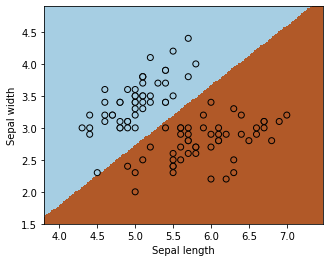

In [10]:
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(5, 4))
plt.pcolormesh(xx, yy, Z, shading='auto', cmap=plt.cm.Paired)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

**对比本文算法的结果可以发现：**

+ 利用sklearn库求解得到的参数值相差不大，有区别的原因主要有以下几个：<br>
1）采用的求解算法不同。sklearn采用随机平均梯度下降（SAG）方法，本文采用批量梯度下降（FG）方法<br>
2）学习步长$\eta$的设定方法不同。SAG采用自动步长，而在本文算法中我们给FG设置了固定步长<br>
3）停止迭代的条件不同。通过查看sklearn相关源码发现，采用SAG算法的停止条件为：max(change in weights) / max(weights) < tol，这与本文算法不同<br><br>
+ sklearn的迭代次数更少，这是因为SAG算法在一次迭代过程中进行了多次参数更新，而FG算法一次迭代只进行一次参数更新，这无疑会降低效率。除此之外，这与$\eta$的设定也有关。

**总结：**本文手动实现的逻辑回归算法取得了较好的分类效果，不可否认sklearn库中集成的逻辑回归方法更为优秀，但本文

目的在于通过简单实现帮助理解算法的基本原理，进一步学习可参考[sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)及源码。

**<font size=4 color='black'>参考</font>**

1 李航. (2012) 统计学习方法. 清华大学出版社, 北京.

2 [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

**<font size=4 color='blue'>附录</font>** 

**sigmoid函数图像**

sigmoid函数的导数最大值: 0.25


Text(0.5, 1.0, 'sigmoid function')

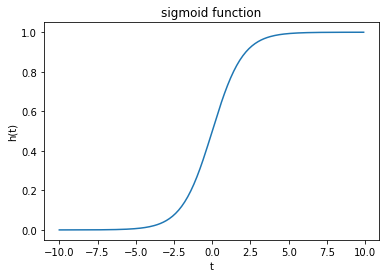

In [11]:
# 绘制sigmoid函数图像
t = np.arange(-10, 10, 0.1)
h = 1 / (1 + np.exp(-t))
max_dh = max(h * (1 - h))
print('sigmoid函数的导数最大值:', max_dh)
plt.plot(t, h)
plt.xlabel('t')
plt.ylabel('h(t)')
plt.title('sigmoid function')